In [13]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import tifffile
import matplotlib.pyplot as plt
import cv2

import random

In [14]:
DEFAULT_RANDOM_SEED = 2021

seed = DEFAULT_RANDOM_SEED

random.seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [15]:
'''DATA LOADER'''
class SWEDDataset(Dataset):
    def __init__(self, root_dir, mode='train', transform=None, target_transform=None, index=True):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        self.target_transform = target_transform
        self.index = index

        self.data_dir = os.path.join(root_dir, mode)
        self.image_dir = os.path.join(self.data_dir, 'images')
        self.label_dir = os.path.join(self.data_dir, 'labels')
        
        image_files = sorted([f for f in os.listdir(self.image_dir) 
                            if f.endswith('.npy' if mode in ['train', 'val'] else '.tif')])
        label_files = sorted([f for f in os.listdir(self.label_dir) 
                            if f.endswith('.npy' if mode in ['train', 'val'] else '.tif')])
        
        self.pairs = []
        label_suffix = '_chip_' if mode in ['train', 'val'] else '_label_'
        image_dict = {f.replace('_image_', label_suffix): f for f in image_files}
        
        for label_file in label_files:
            if label_file in image_dict:
                self.pairs.append((image_dict[label_file], label_file))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_file, label_file = self.pairs[idx]
        img_path = os.path.join(self.image_dir, img_file)
        label_path = os.path.join(self.label_dir, label_file)
        
        if self.mode in ['train', 'val']:
            image = np.load(img_path)
            label = np.load(label_path)
        else:
            image = tifffile.imread(img_path)
            label = tifffile.imread(label_path)
            
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()
        
        if self.mode in ['train', 'val']:
            image = image.permute(2, 0, 1)
        elif self.mode == 'test':
            image = image.permute(0, 2, 1)
            label = label.unsqueeze(0)
            label = torch.rot90(label, 1, [1, 2])
            label = torch.flip(label, [1])

        image = image / 2.0**15     # jp2 images are 8 to 16 bit
        label = label > 0.0         # binary label

        # bands: B1, B2, B3, B4, B5, B6, B7, B8, B8A, B9, B11, B12
        if self.index:
            ndwi1 = (image[2] - image[7]) / (image[2] + image[7] + 1e-6)
            
            # downsample
            lowres = image[2].T.cpu().numpy()
            original_shape = lowres.shape
            lowres = cv2.resize(
                lowres, 
                (lowres.shape[1] // 2, lowres.shape[0] // 2), 
                interpolation=cv2.INTER_CUBIC
            )
            lowres = cv2.resize(
                lowres, 
                (original_shape[1], original_shape[0]), 
                interpolation=cv2.INTER_CUBIC
            )
            lowres = torch.from_numpy(lowres.T).float()

            ndwi2 = (lowres - image[10]) / (lowres + image[10] + 1e-6)

            image = torch.cat([image, ndwi1.unsqueeze(0), ndwi2.unsqueeze(0)], dim=0)
            
        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

In [16]:
'''GET DATA LOADER'''
def get_dataloaders(root_dir, batch_size=32, num_workers=4, train_transform=None, test_transform=None, device='cuda'):
    train_dataset = SWEDDataset(root_dir, mode='train', transform=train_transform)
    test_dataset = SWEDDataset(root_dir, mode='test', transform=test_transform)

    # train_dataset, val_dataset, _ = random_split(train_dataset, [int(0.01 * len(train_dataset)), 
    #                                                              int(0.01 * len(train_dataset)), 
    #                                                              len(train_dataset) - int(0.02 * len(train_dataset))])

    train_dataset, val_dataset = random_split(train_dataset, [int(0.8 * len(train_dataset)),  
                                                                 len(train_dataset) - int(0.8 * len(train_dataset))])

    print(f'Train size: {len(train_dataset)}')
    print(f'Validation size: {len(val_dataset)}')
    print(f'Test size: {len(test_dataset)}')
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader

In [17]:
'''DISPLAY SAMPLES'''
def display_samples(dataloader, num_samples=5, index=True):
    # Get a batch
    images, masks = next(iter(dataloader))

    # Move to CPU for visualization
    images = images.cpu()
    masks = masks.cpu()

    # Only display up to the requested number of samples
    num_samples = min(num_samples, len(images))
    
    rows = 4 if index else 2
    fig, axes = plt.subplots(rows, num_samples, figsize=(5*num_samples, 5*rows))
    
    idx = 0
    while(idx < num_samples):
        i = np.random.randint(0, len(images))
        if masks[i].sum() == 0:
            continue

        # Display RGB channels (assuming bands 3,2,1 are RGB)
        rgb_img = images[i][[3,2,1]].permute(1,2,0)
        # Normalize for visualization
        rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())
        
        axes[0, idx].imshow(rgb_img)
        axes[0, idx].axis('off')
        axes[0, idx].set_title(f'Image {idx+1}')
        
        axes[1, idx].imshow(masks[i][0], cmap='gray')
        axes[1, idx].axis('off')
        axes[1, idx].set_title(f'Mask {idx+1}')

        if index:
            axes[2, idx].imshow(images[i][12], cmap='gray')
            axes[2, idx].axis('off')
            axes[2, idx].set_title(f'NDWI1 {idx+1}')

            axes[3, idx].imshow(images[i][13], cmap='gray')
            axes[3, idx].axis('off')
            axes[3, idx].set_title(f'NDWI2 {idx+1}')

        idx += 1
    
    plt.tight_layout()
    plt.show()

In [18]:
'''VISUALIZE SAMPLES'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(f"Using device: {device}")

root_dir = "/kaggle/input/sentinel-2-water-edges-dataset/SWED"
train_loader, val_loader, test_loader = get_dataloaders(root_dir, batch_size=16, num_workers=4)

# Display 5 samples from training set
# display_samples(train_loader, num_samples=5)
# display_samples(test_loader, num_samples=5)

'''
# in case we need standardization

channel-wise mean:  tensor([ 532.5187,  636.4246,  892.5240, 1049.9366, 1307.1577, 1738.9155,
        1915.7476, 1995.0083, 2055.7939, 2086.2705, 2001.6875, 1491.3577])
channel-wise std:  tensor([ 679.3956,  750.0253,  923.6580, 1273.5732, 1366.0400, 1500.5621,
        1623.3806, 1687.1169, 1720.2144, 1827.5625, 1932.8875, 1631.7715])
'''

Using device: cuda
Train size: 22579
Validation size: 5645
Test size: 98


'\n# in case we need standardization\n\nchannel-wise mean:  tensor([ 532.5187,  636.4246,  892.5240, 1049.9366, 1307.1577, 1738.9155,\n        1915.7476, 1995.0083, 2055.7939, 2086.2705, 2001.6875, 1491.3577])\nchannel-wise std:  tensor([ 679.3956,  750.0253,  923.6580, 1273.5732, 1366.0400, 1500.5621,\n        1623.3806, 1687.1169, 1720.2144, 1827.5625, 1932.8875, 1631.7715])\n'

In [19]:
!pip install -q --upgrade torchmetrics

In [20]:
'''TRAINER CLASS'''
from tqdm import tqdm
from torchmetrics.classification import (
    BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score, BinaryJaccardIndex, 
    BinaryCohenKappa, BinaryMatthewsCorrCoef, Accuracy
)
import pandas as pd

class Trainer:
    def __init__(self, model, criterion, optimizer, train_loader, val_loader, test_loader, device, 
                 scheduler=None, early_stopping_patience=8, min_delta=0.001):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.scheduler = scheduler
        self.predictions = None

        # Early stopping parameters
        self.early_stopping_patience = early_stopping_patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.early_stopping_counter = 0
        self.early_stopped = False

    def save_checkpoint(self, epoch, train_loss, val_loss, best_model=False):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses
        }
        if self.scheduler:
            checkpoint['scheduler_state_dict'] = self.scheduler.state_dict()

        if best_model:
            save_path = 'best_model.pt'
        else:
            save_path = 'checkpoint.pt'
        torch.save(checkpoint, save_path)
    
    def load_checkpoint(self, checkpoint_path="best_model.pt"):
        if not os.path.exists(checkpoint_path):
            return 0  # Start from scratch if no checkpoint exists
            
        checkpoint = torch.load(checkpoint_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if self.scheduler and 'scheduler_state_dict' in checkpoint:
            self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        # Restore loss history
        self.train_losses = checkpoint.get('train_losses', [])
        self.val_losses = checkpoint.get('val_losses', [])
        
        return checkpoint['epoch']

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        for images, labels in tqdm(self.train_loader, desc="train"):
            images, labels = images.to(self.device), labels.to(self.device).float()
            
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs.squeeze(), labels.squeeze())
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        return running_loss / len(self.train_loader.dataset)

    def val_epoch(self):
        self.model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for images, labels in tqdm(self.val_loader, desc="validation"):
                images, labels = images.to(self.device), labels.to(self.device).float()
                outputs = self.model(images)
                loss = self.criterion(outputs.squeeze(), labels.squeeze())
                running_loss += loss.item() * images.size(0)
        
        return running_loss / len(self.val_loader.dataset)
    
    def plot_losses(self, train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
        plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()
    
    def train(self, num_epochs, do_plot=True, plot_interval=2, resume=True):
        # Initialize or restore from checkpoint
        self.train_losses = []
        self.val_losses = []
        start_epoch = self.load_checkpoint('checkpoint.pt') if resume else 0
        self.best_val_loss = float('inf')
        self.early_stopping_counter = 0
        self.early_stopped = False

        if start_epoch > 0:
            print("Training resumed from epoch ", start_epoch)
    
        for epoch in range(start_epoch, num_epochs):
            if self.early_stopped:
                print("Early stopping triggered.")
                break

            train_loss = self.train_epoch()
            val_loss = self.val_epoch()
    
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            
            if self.scheduler:
                self.scheduler.step(val_loss)
    
            print(f"Epoch {epoch + 1}/{num_epochs}")
            print(f"Training Loss: {train_loss:.4f}")
            print(f"Validation Loss: {val_loss:.4f}")

            self.save_checkpoint(epoch + 1, train_loss, val_loss)
    
            # Early stopping logic
            if val_loss < self.best_val_loss - self.min_delta:
                self.best_val_loss = val_loss
                self.early_stopping_counter = 0
                # Save the best model
                self.save_checkpoint(epoch + 1, train_loss, val_loss, best_model=True)
                print(f"New best model saved at epoch {epoch + 1}")
            else:
                self.early_stopping_counter += 1
                print(f"No improvement. Early stopping counter: {self.early_stopping_counter}")
                
                if self.early_stopping_counter >= self.early_stopping_patience:
                    self.early_stopped = True
                    print("Early stopping triggered.")
    
            if do_plot and (epoch % plot_interval == 0 or epoch == num_epochs - 1):
                self.plot_losses(self.train_losses, self.val_losses)
        
        # Load the best model at the end of training
        if os.path.exists('best_model.pt'):
            self.load_checkpoint('best_model.pt')
        
        return self.early_stopped


    def test(self, thres=0.5):
        self.load_checkpoint('best_model.pt')
        self.model.eval()
        running_loss = 0.0
        all_predictions = []
        y_true = None
        y_pred = None

        with torch.no_grad():
            for images, labels in tqdm(self.test_loader, desc="Testing"):
                images, labels = images.to(self.device), labels.to(self.device).float()
                outputs = self.model(images)

                if y_true is None:
                    y_true = labels.squeeze().cpu().numpy()
                    y_pred = (outputs.squeeze().cpu().numpy() > thres).astype(int)
                else:
                    y_true = np.concatenate((y_true, labels.squeeze().cpu().numpy()))
                    y_pred = np.concatenate((y_pred, (outputs.squeeze().cpu().numpy() > 0.5).astype(int)))
                
                loss = self.criterion(outputs.squeeze(), labels.squeeze())
                running_loss += loss.item() * images.size(0)
                all_predictions.extend(outputs.squeeze().cpu().numpy())

        metrics = self.evaluate_torchmetrics(y_pred, y_true)
        metrics.loc[len(metrics)] = ['loss', running_loss / len(self.test_loader.dataset)]  

        return metrics

    def evaluate_torchmetrics(self, y_pred, y_true):
        metrics = {
            "accuracy": BinaryAccuracy(),
            "bal_accuracy": Accuracy(num_classes=2, task="multiclass", average="macro"),
            "precision": BinaryPrecision(),
            "recall": BinaryRecall(),
            "f1_score": BinaryF1Score(),
            "jaccard_index": BinaryJaccardIndex(),
            "cohen_kappa": BinaryCohenKappa(),
            "mcc": BinaryMatthewsCorrCoef()
        }
    
        y_pred = torch.tensor(y_pred).float()
        y_true = torch.tensor(y_true).float()
    
        # result dataframe
        results = pd.DataFrame(columns=["Metric", "Value"])
        for metric_name, metric in metrics.items():
            metric_value = metric(y_pred, y_true)
            results.loc[len(results)] = [metric_name, metric_value.item()]  
            
        return results

    def test_visualize(self, n_samples=5, thres=0.5): 
        self.model.eval()
        y_true = None
        y_pred = None

        with torch.no_grad():
            for images, labels in tqdm(self.test_loader, desc="Testing"):
                images, labels = images.to(self.device), labels.to(self.device).float()
                outputs = self.model(images)

                if y_true is None:
                    y_true = labels.squeeze().cpu().numpy()
                    y_pred = (outputs.squeeze().cpu().numpy() >thres).astype(int)
                else:
                    y_true = np.concatenate((y_true, labels.squeeze().cpu().numpy()))
                    y_pred = np.concatenate((y_pred, (outputs.squeeze().cpu().numpy() > 0.5).astype(int)))
                
        for _ in range(n_samples):
            idx = random.randint(0, len(y_true))
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(y_true[idx].reshape(256, 256), cmap='gray')
            axes[0].set_title('True')
            axes[1].imshow(y_pred[idx].reshape(256, 256), cmap='gray')
            axes[1].set_title('Predicted')
            plt.show()


In [21]:
channels = 14

In [22]:
class ChannelAttentionBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttentionBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction),
            nn.GELU(),
            nn.Linear(in_channels // reduction, in_channels)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x).squeeze())
        max_out = self.fc(self.max_pool(x).squeeze())
        out = avg_out + max_out
        return self.sigmoid(out).unsqueeze(2).unsqueeze(3)
    
class SpatialAttentionBlock(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttentionBlock, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return self.sigmoid(out)
    
class CBAMBlock(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super(CBAMBlock, self).__init__()
        self.channel_attention = ChannelAttentionBlock(in_channels, reduction)
        self.spatial_attention = SpatialAttentionBlock(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x
    
class UNetCBAM(nn.Module):
    def __init__(self, in_channels, out_channels, init_features=32):
        super(UNetCBAM, self).__init__()
        features = init_features
        self.encoder = nn.ModuleList()
        for _ in range(4):
            self.encoder.append(self._block(in_channels, features))
            in_channels = features
            features *= 2
        
        self.bottleneck = self._block(in_channels, features)
        
        self.decoder = nn.ModuleList()
        for _ in range(4):
            self.decoder.append(self._block(features, features // 2))
            features //= 2
        
        self.final_conv = nn.Conv2d(features, out_channels, kernel_size=1)
        
        self.cbam = CBAMBlock(features)
    
    def _block(self, in_channels, features):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=3, padding=1),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True)
        )

    def _upblock(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        encoder_outputs = []
        for block in self.encoder:
            x = block(x)
            encoder_outputs.append(x)
            x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
        
        x = self.bottleneck(x)
        
        for block, encoder_output in zip(self.decoder, reversed(encoder_outputs)):
            up_block = self._upblock(x.size(1), encoder_output.size(1)).to(x.device)
            x = up_block(x)
            x = torch.cat([x, encoder_output], dim=1)
            x = block(x)
        
        x = self.cbam(x)
        x = self.final_conv(x)
        return x
    
model = UNetCBAM(in_channels=channels, out_channels=1, init_features=32).to(device)
input_img = torch.randn(16, channels, 256, 256).to(device)
output_img = model(input_img)
print(output_img.shape)

torch.Size([16, 1, 256, 256])


In [23]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.6, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce_loss = nn.BCEWithLogitsLoss(reduction="none")
    
    def forward(self, pred, target):
        pred, target = pred.squeeze(), target.squeeze()
        loss = self.bce_loss(pred, target)
        prob = torch.sigmoid(pred)  # Predicted probability
        alpha = torch.where(target == 1, self.alpha, 1 - self.alpha)  # Class balancing factor
        focal_weight = torch.where(target == 1, 1 - prob, prob)  # Focusing weight
        focal_weight = alpha * focal_weight**self.gamma  # Apply alpha and gamma
        focal_loss = focal_weight * loss
        
        focal_loss = focal_loss.sum(dim=(-2,-1)) #*mask
        return focal_loss.mean()

def loss(pred, target):
#     print(pred.shape, target.shape)
    bce_loss = nn.BCEWithLogitsLoss(reduction="none") 
    ll = bce_loss(pred, target)

    ll = ll.sum(dim=(-2,-1)) #*mask
    return ll.mean()


pred = torch.randn(16, 128, 128).float()
target = torch.randint(0, 2, (16, 128, 128)).float()

# focal_loss = FocalLoss(alpha=0.75, gamma=2.0)
# focal_loss(pred, target)
loss(pred, target)

tensor(13211.0068)

validation: 100%|██████████| 353/353 [00:52<00:00,  6.70it/s]


Epoch 1/30
Training Loss: 2098.4711
Validation Loss: 2730.0531
New best model saved at epoch 1


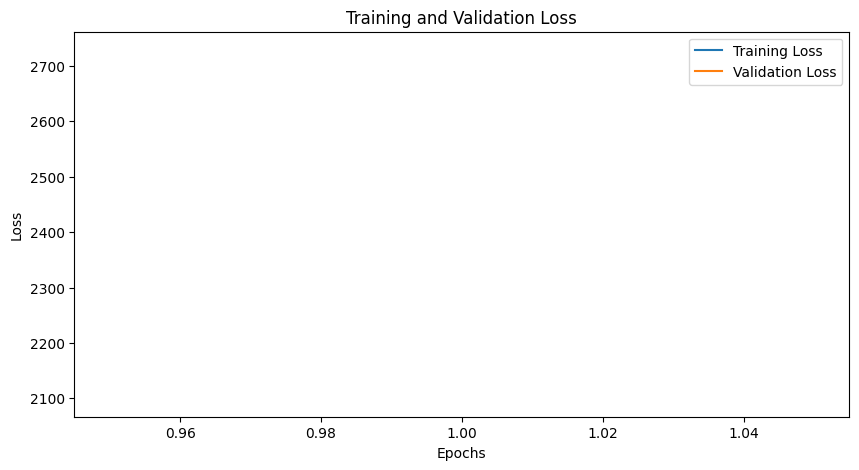

validation: 100%|██████████| 353/353 [00:46<00:00,  7.53it/s]


Epoch 2/30
Training Loss: 1411.6077
Validation Loss: 2251.6623
New best model saved at epoch 2


validation: 100%|██████████| 353/353 [00:58<00:00,  6.03it/s]


Epoch 3/30
Training Loss: 1242.7382
Validation Loss: 1067.3378
New best model saved at epoch 3


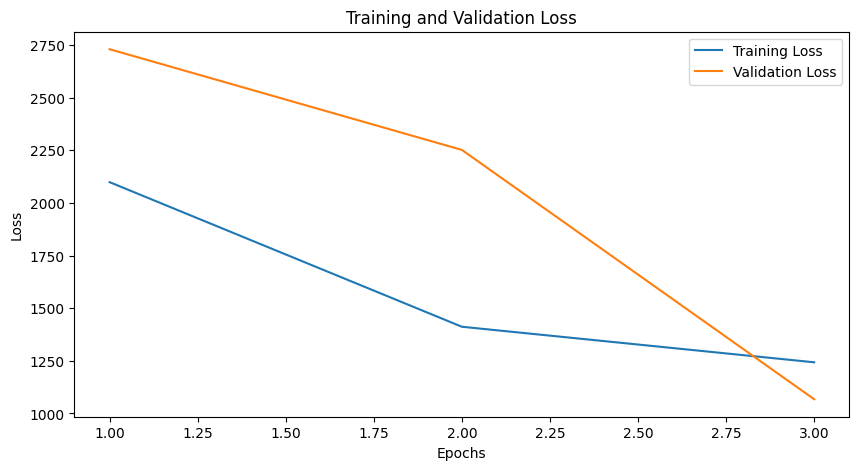

validation: 100%|██████████| 353/353 [00:48<00:00,  7.25it/s]


Epoch 4/30
Training Loss: 1113.4546
Validation Loss: 1021.0272
New best model saved at epoch 4


validation: 100%|██████████| 353/353 [00:55<00:00,  6.38it/s]


Epoch 5/30
Training Loss: 966.7452
Validation Loss: 920.8326
New best model saved at epoch 5


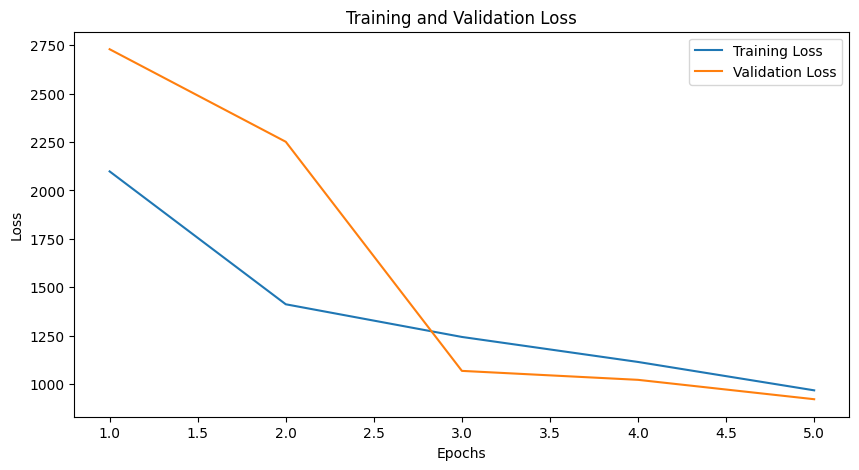

validation: 100%|██████████| 353/353 [00:47<00:00,  7.36it/s]


Epoch 6/30
Training Loss: 835.0950
Validation Loss: 11212.2421
No improvement. Early stopping counter: 1


validation: 100%|██████████| 353/353 [01:01<00:00,  5.76it/s]


Epoch 7/30
Training Loss: 716.9268
Validation Loss: 2397.7071
No improvement. Early stopping counter: 2


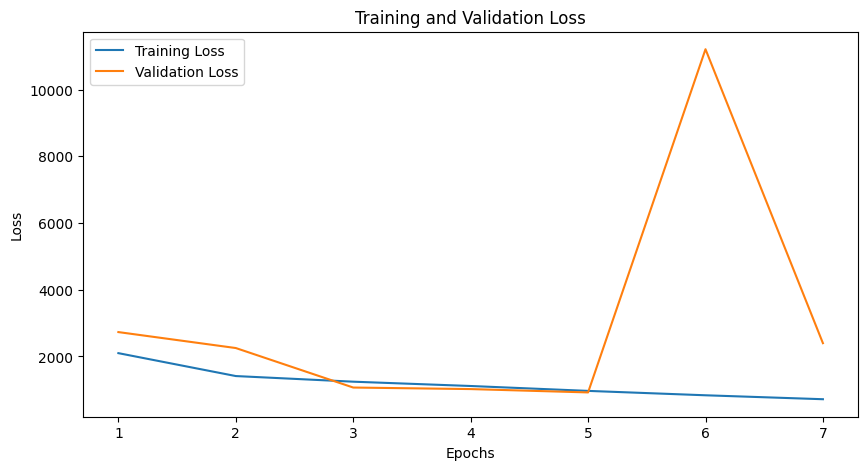

validation: 100%|██████████| 353/353 [00:43<00:00,  8.05it/s]


Epoch 8/30
Training Loss: 640.1986
Validation Loss: 1502.2369
No improvement. Early stopping counter: 3


validation: 100%|██████████| 353/353 [00:57<00:00,  6.13it/s]


Epoch 9/30
Training Loss: 576.2981
Validation Loss: 10936.7577
No improvement. Early stopping counter: 4


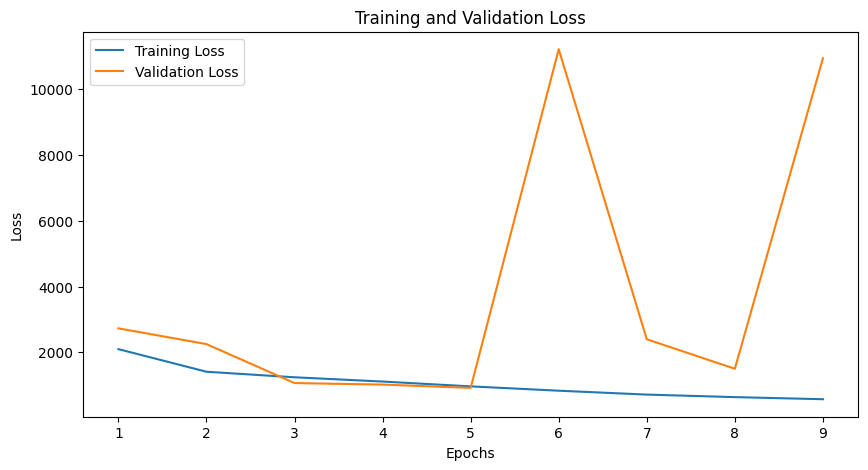

validation: 100%|██████████| 353/353 [00:45<00:00,  7.70it/s]


Epoch 10/30
Training Loss: 512.8879
Validation Loss: 13355.9954
No improvement. Early stopping counter: 5


validation: 100%|██████████| 353/353 [00:59<00:00,  5.94it/s]


Epoch 11/30
Training Loss: 487.1499
Validation Loss: 20757.8104
No improvement. Early stopping counter: 6


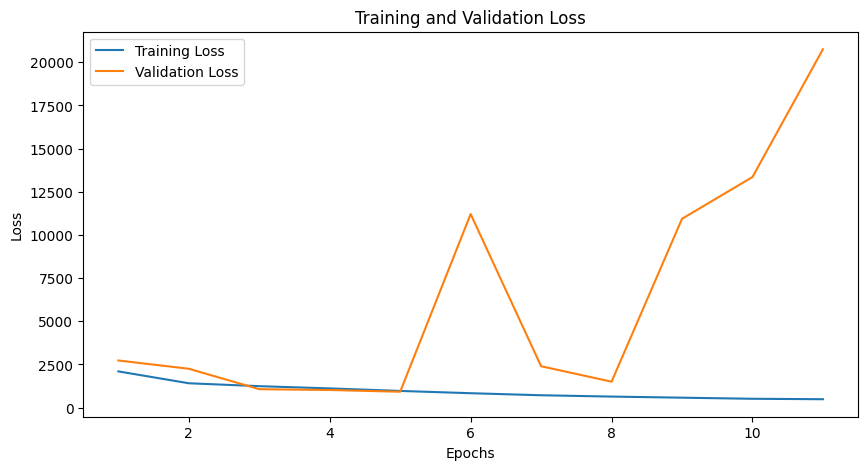

validation: 100%|██████████| 353/353 [00:43<00:00,  8.15it/s]


Epoch 12/30
Training Loss: 401.6993
Validation Loss: 339.9644
New best model saved at epoch 12


validation: 100%|██████████| 353/353 [00:57<00:00,  6.12it/s]


Epoch 13/30
Training Loss: 384.6800
Validation Loss: 352.8043
No improvement. Early stopping counter: 1


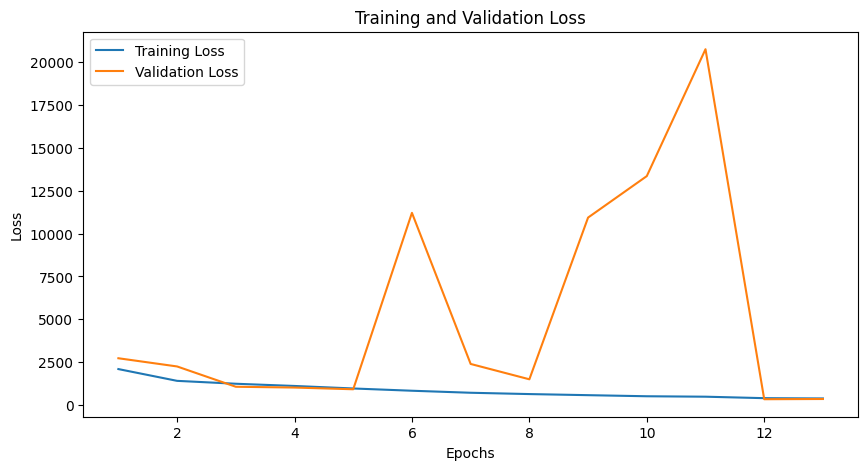

validation: 100%|██████████| 353/353 [00:45<00:00,  7.74it/s]


Epoch 14/30
Training Loss: 378.6784
Validation Loss: 462.9223
No improvement. Early stopping counter: 2


validation: 100%|██████████| 353/353 [00:50<00:00,  7.04it/s]


Epoch 15/30
Training Loss: 362.4924
Validation Loss: 26172.9546
No improvement. Early stopping counter: 3


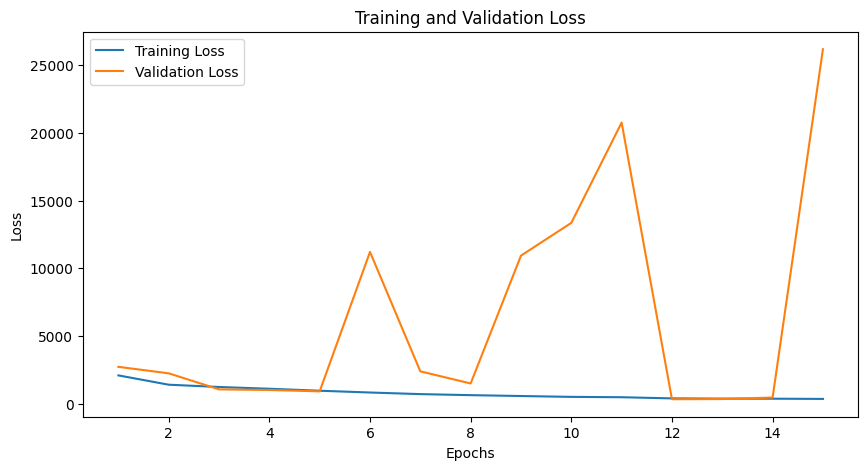

validation: 100%|██████████| 353/353 [00:44<00:00,  7.89it/s]


Epoch 16/30
Training Loss: 350.0796
Validation Loss: 340.2263
No improvement. Early stopping counter: 4


validation: 100%|██████████| 353/353 [00:52<00:00,  6.71it/s]


Epoch 17/30
Training Loss: 321.7212
Validation Loss: 22303.2904
No improvement. Early stopping counter: 5


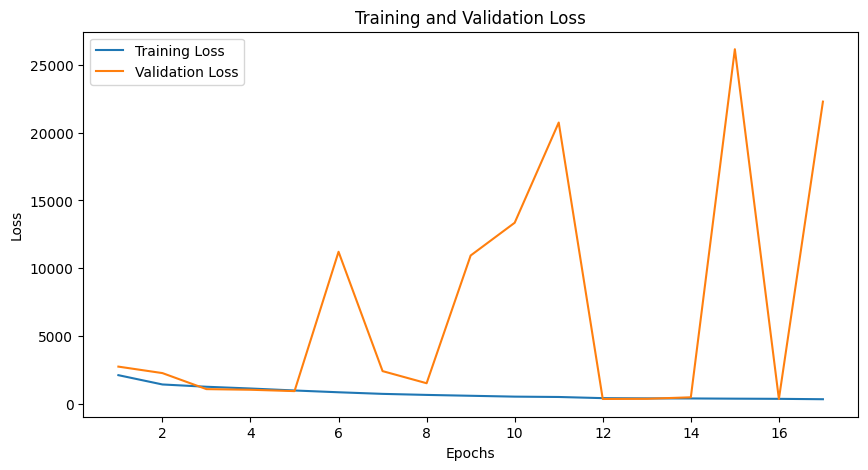

validation: 100%|██████████| 353/353 [00:43<00:00,  8.05it/s]


Epoch 18/30
Training Loss: 326.3363
Validation Loss: 703.5455
No improvement. Early stopping counter: 6


validation: 100%|██████████| 353/353 [00:51<00:00,  6.90it/s]


Epoch 19/30
Training Loss: 291.7148
Validation Loss: 1999.9733
No improvement. Early stopping counter: 7


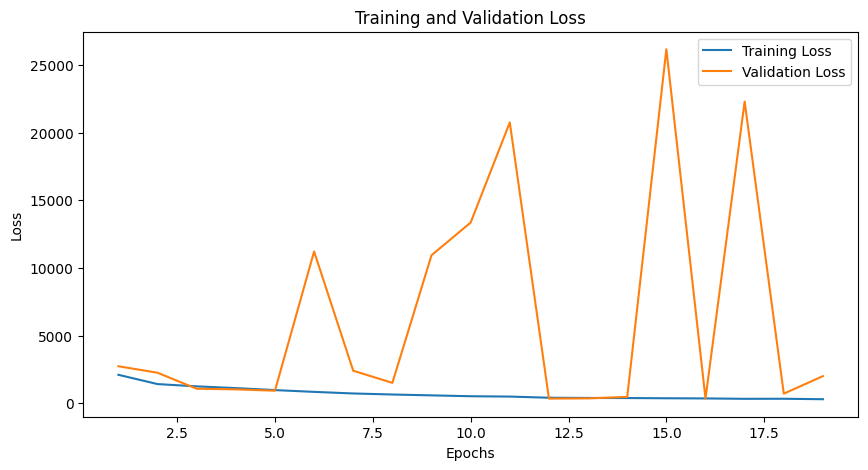

validation: 100%|██████████| 353/353 [00:49<00:00,  7.20it/s]


Epoch 20/30
Training Loss: 275.3267
Validation Loss: 1327.2105
No improvement. Early stopping counter: 8
Early stopping triggered.
Early stopping triggered.


/tmp/ipykernel_30/740989651.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


True

In [24]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd

criterion = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

trainer = Trainer(model, criterion, optimizer, train_loader, val_loader, test_loader, device, scheduler)
trainer.train(num_epochs=30)

In [25]:
metrics_df = trainer.test(thres=0.5)
metrics_df

/tmp/ipykernel_30/740989651.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
Testing: 100%|██████████| 7/7 [00:02<00:00,  3.04it

,Metric,Value
0,accuracy,0.913052
1,bal_accuracy,0.914918
2,precision,0.943596
3,recall,0.902053
4,f1_score,0.922357
5,jaccard_index,0.855902
6,cohen_kappa,0.823685
7,mcc,0.824763
8,loss,3070.940805


Testing: 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]


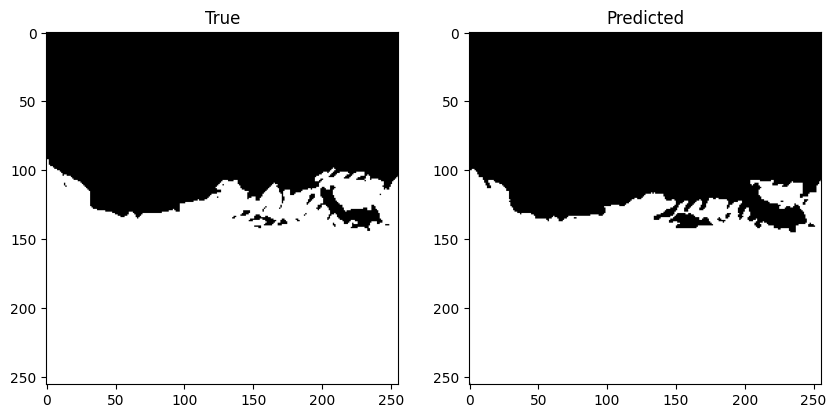

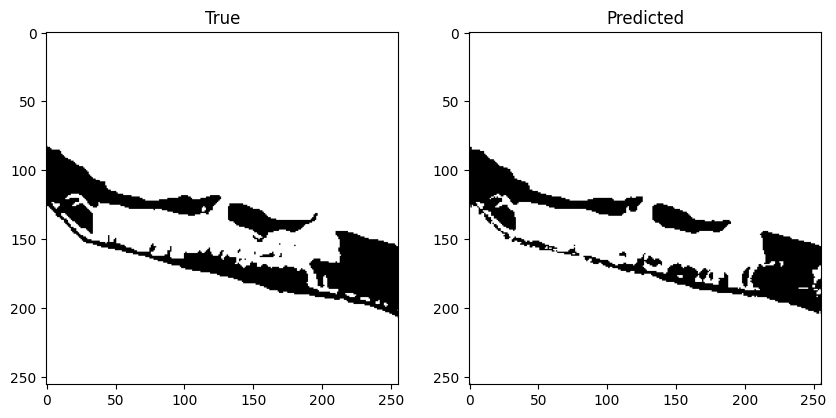

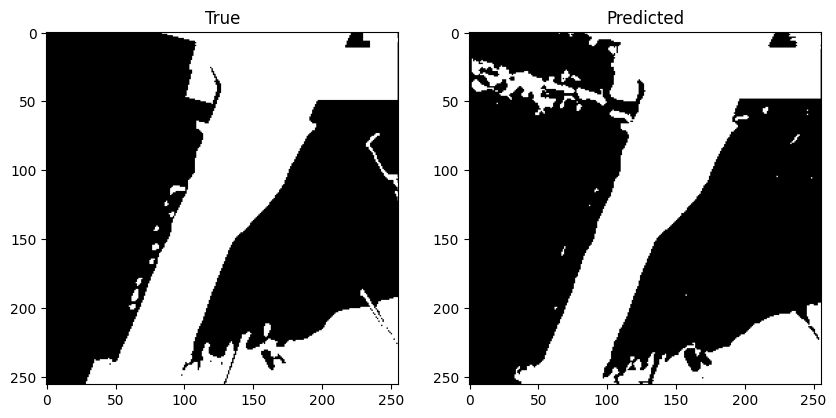

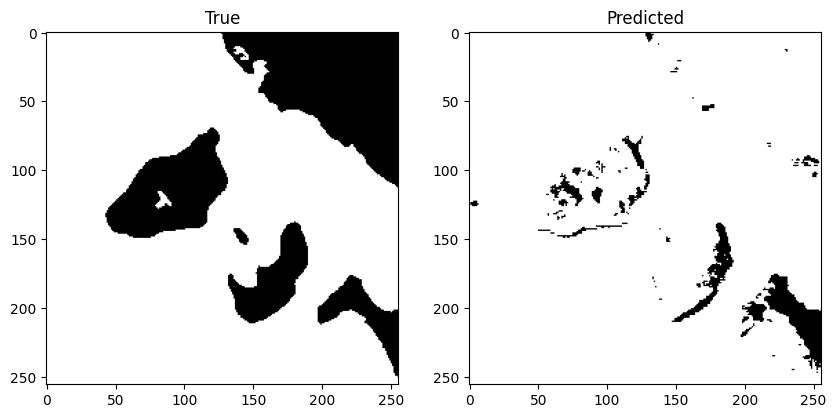

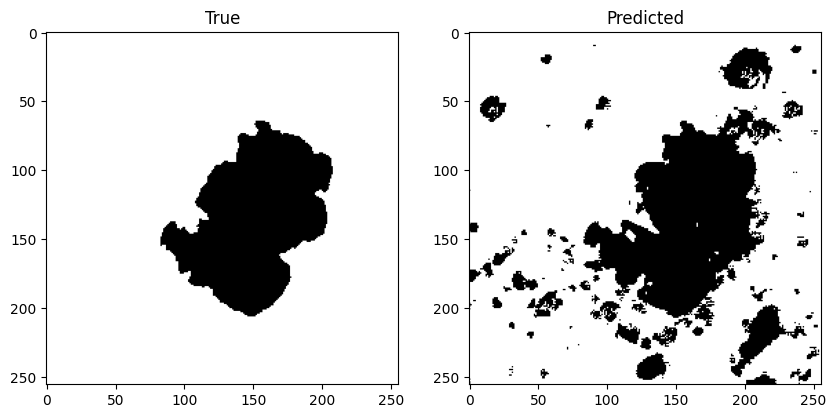

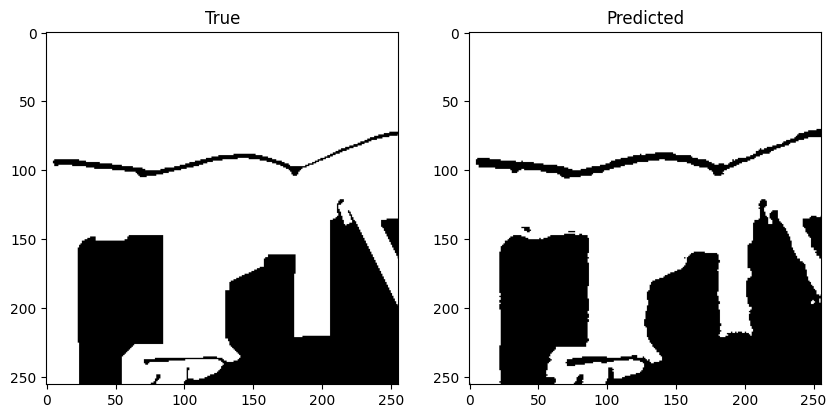

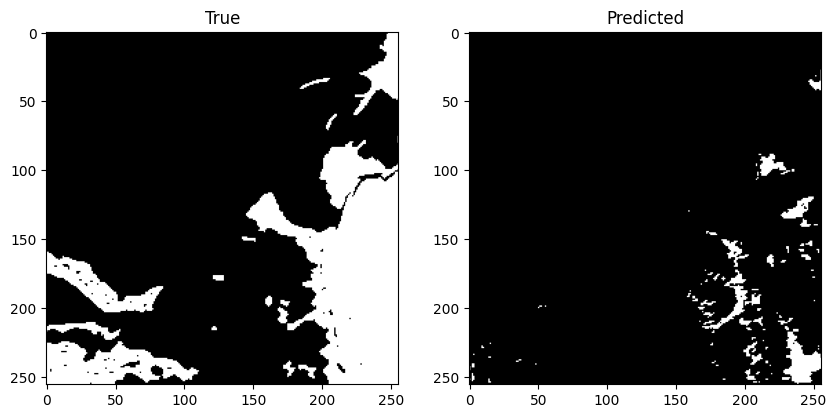

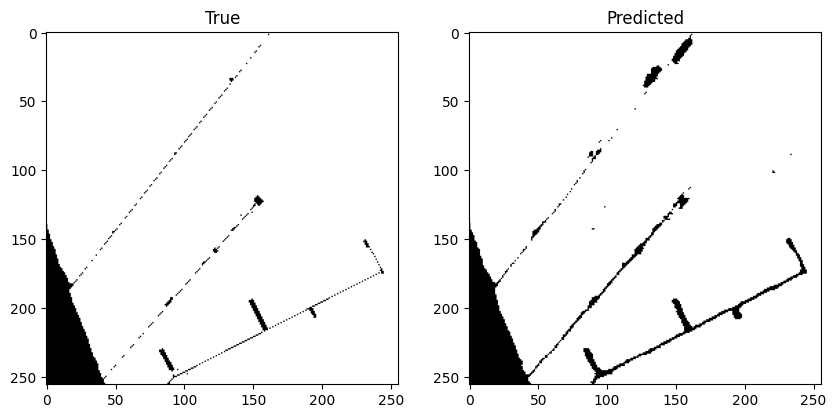

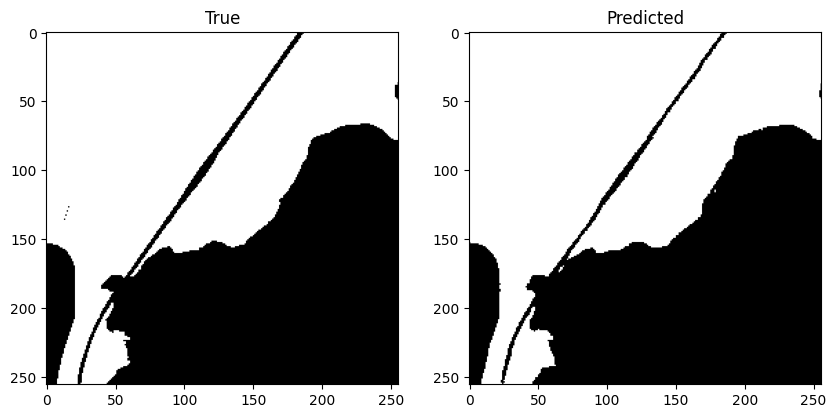

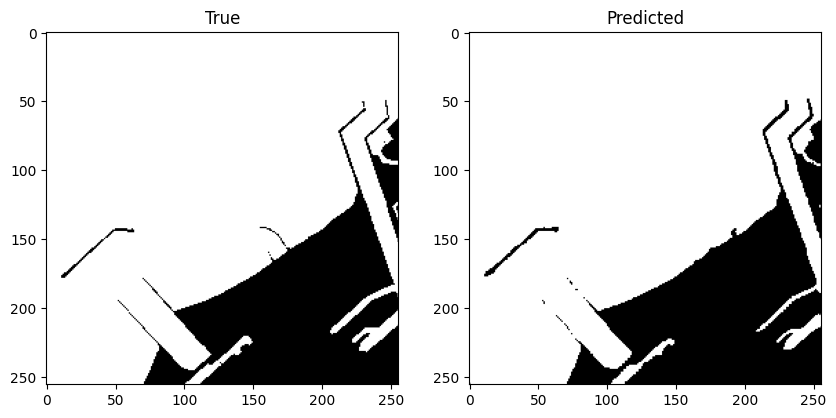

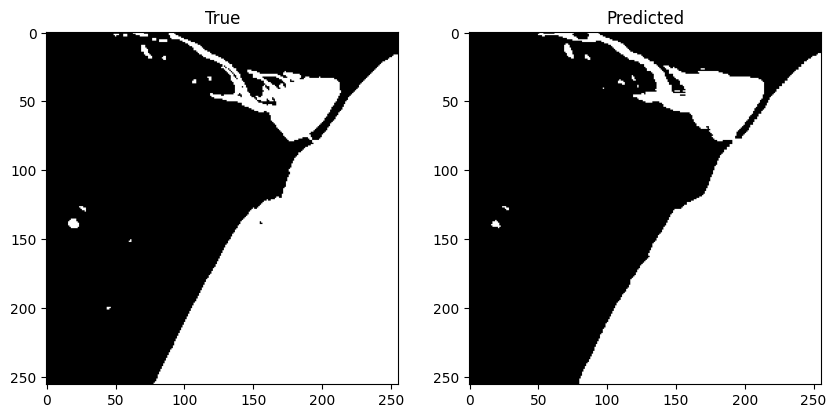

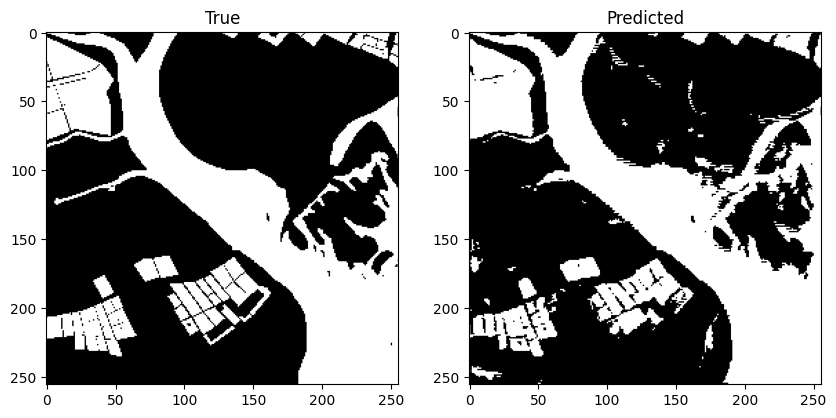

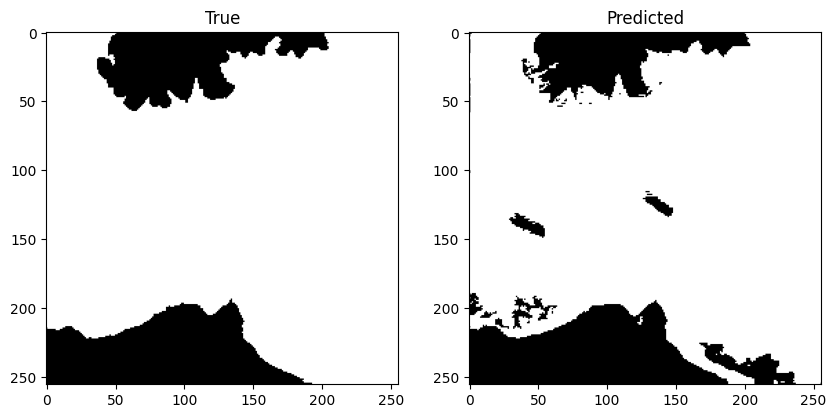

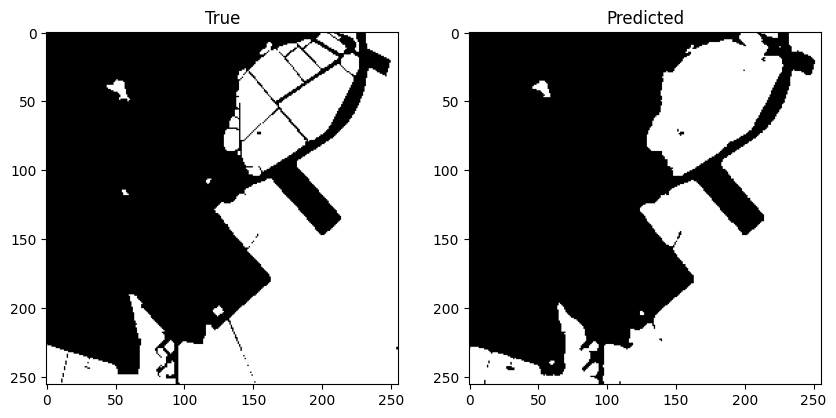

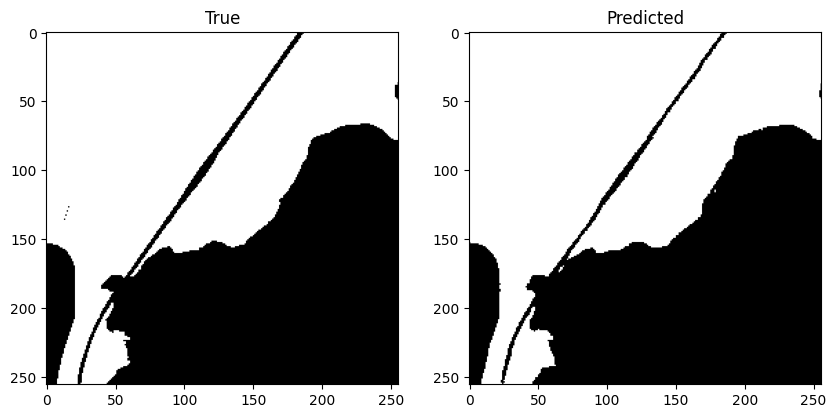

In [26]:
trainer.test_visualize(15, 0.5)

In [27]:
# !rm -r /kaggle/working/*